# Testing Paolina on output of Penthesilea (run on NEW data)

In [1]:
%matplotlib inline

import os
import sys
import random
import tables as tb
import numpy  as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from   invisible_cities.reco.paolina_functions import \
            Voxel, build_voxels, calc_adj_matrix, construct_tracks, calc_dist_mat, construct_blobs
from   invisible_cities.cities.penthesilea import Penthesilea, PENTHESILEA
from   invisible_cities.database import load_db
from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.reco.pmaps_functions import load_pmaps, integrate_charge, plot_s2si_map, select_si_slice
from   invisible_cities.reco.tbl_functions     import get_event_numbers_and_timestamps
from   invisible_cities.reco.xy_algorithms import barycenter, corona
from   invisible_cities.reco.dst_io import Hit, HitCollection

#from   icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, print_fit, chi2
from invisible_cities.core.core_functions import in_range

NSIPM = 1792

In [ ]:
conf_file_name = os.path.join(os.environ['ICDIR']) + 'config/penthesilea.conf'
PENTHESILEA(['PENTHESILEA', '-c', conf_file_name])

In [2]:
# read in the output HitCollection
fn = tb.open_file('/Users/jrenner/IFIC/IC-1/invisible_cities/database/test_data/NaTracks_3755.h5','r')
tracks = fn.root.DST.Tracks
nmax = 17468

# loop over all events
rnum = 0       # row number in table iteration
ev = 0         # processed event number
hc_evt = []
while(rnum < tracks.nrows and ev < nmax):
    
    # create a HitCollection
    hitc = HitCollection()

    # fill the hit for this event
    evtnum = tracks[rnum]['event']
    while(rnum < tracks.nrows and tracks[rnum]['event'] == evtnum):
        hit       = Hit()
        hit.Npeak = tracks[rnum]['npeak']
        hit.X     = tracks[rnum]['X']
        hit.Y     = tracks[rnum]['Y']
        hit.R     = tracks[rnum]['R']
        hit.Phi   = tracks[rnum]['Phi']
        hit.Nsipm = tracks[rnum]['Nsipm']
        hit.Z     = tracks[rnum]['Z']
        hit.Q     = tracks[rnum]['Q']
        hit.E     = tracks[rnum]['E']
        hit.Ecorr = tracks[rnum]['Ecorr']
        hitc.append(hit)
        rnum += 1
    
    # add this hit collection to the list of hit collections
    hc_evt.append(hitc)
    ev += 1

print("Read in {0} events".format(len(hc_evt)))

Read in 6933 events


# Paolina analysis

In [21]:
vol_min = np.array([-250, -250, -100],dtype=np.int16)  # volume minimum (x,y,z)
vol_max = np.array([250, 250, 400],dtype=np.int16)  # volume maximum (x,y,z)
vox_size = np.array([10, 10, 5],dtype=np.int16)    # voxel size
blob_radius = 15.                    # blob radius in mm
Ecut_low = 80000
Ecut_high = 109000
Ecut_low_blobs = 4000

## Individual tracks

(array([ 141.,  254.,  296.,  317.,  296.,  277.,  318.,  372.,  407.,
         413.,  398.,  350.,  252.,  199.,  216.,  300.,  422.,  645.,
         500.,  273.,   81.,   29.,   20.,   18.,   12.,   10.,    7.,
           4.,    6.,    5.,    6.,    5.,    3.,    4.,    4.,    3.,
           5.,    1.,    3.,    0.,    1.,    2.,    2.,    1.,    0.,
           0.,    2.,    0.,    0.,    1.,    1.,    1.,    5.,    0.,
           1.,    1.,    1.,    2.,    1.,    1.,    2.,    0.,    2.,
           1.,    2.,    2.,    1.,    1.,    1.,    2.,    1.,    3.,
           1.,    2.,    4.,    0.,    0.,    1.,    1.,    0.,    1.,
           0.,    1.,    0.,    0.,    0.,    0.,    0.,    1.,    0.,
           1.,    2.,    0.,    1.,    0.,    1.,    1.,    1.,    0.,    1.]),
 array([    692.53688049,    5929.00662277,   11165.47636505,
          16401.94610733,   21638.41584961,   26874.88559189,
          32111.35533417,   37347.82507645,   42584.29481873,
          47820.764561  

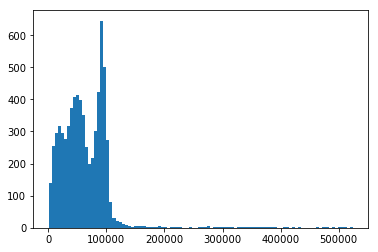

In [4]:
e_spec = []
for ee in range(len(hc_evt)):
    evt_E = sum([hh.E for hh in hc_evt[ee]])
    e_spec.append(evt_E)
    #if(evt_E > 200000): print(ee)
    #print("Event {0} with total energy {1}".format(ee,evt_E))
plt.hist(e_spec,bins=100)

Event 5 with total energy 93211.83000183104


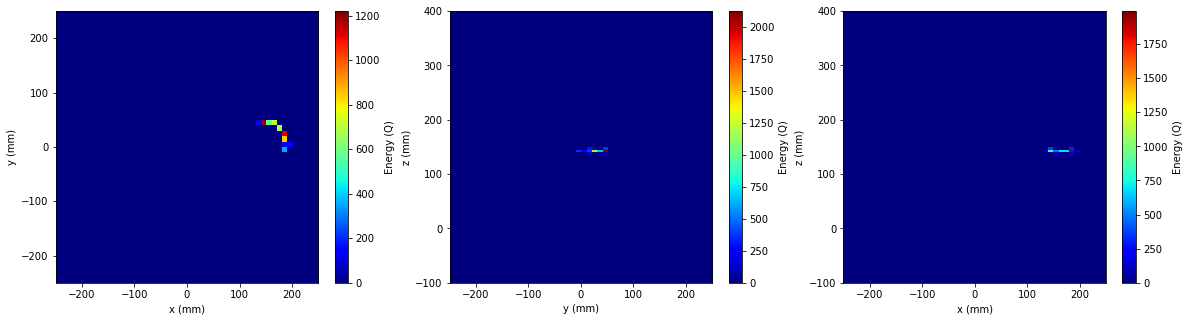

In [25]:
# perform the Paolina analysis for a single event
ee = 5
hitc = hc_evt[ee]
evt_E = sum([hh.E for hh in hitc])
print("Event {0} with total energy {1}".format(ee,evt_E))

voxelc = build_voxels(hitc)
adj_mat = calc_adj_matrix(voxelc)
itmax,trks = construct_tracks(voxelc,adj_mat)
dist_mat, spath = calc_dist_mat(trks[itmax])
Eblob1, Eblob2 = construct_blobs(trks[itmax],dist_mat,spath)

# plot the voxelized tracks
# 2D histogram
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(20.0);

varr_x = []; varr_y = []; varr_z = []; varr_c = []
for vv in trks[itmax]:
#for vv in voxelc:
    varr_x.append(vv.X)
    varr_y.append(vv.Y)
    varr_z.append(vv.Z)
    varr_c.append(vv.E)

vtrk_max = np.array([np.max(varr_x),np.max(varr_y),np.max(varr_z)])
vtrk_min = np.array([np.min(varr_x),np.min(varr_y),np.min(varr_z)])

# create the x-y projection
ax1 = fig.add_subplot(131);
hxy, xxy, yxy = np.histogram2d(varr_y, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[1]-vol_min[1])/vox_size[1], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[1],vol_max[1]],[vol_min[0],vol_max[0]]])
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = ax1.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
cbp1 = plt.colorbar(sp1)
cbp1.set_label('Energy (Q)')

# Create the y-z projection.
ax2 = fig.add_subplot(132);
hyz, xyz, yyz = np.histogram2d(varr_z, varr_y, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[1]-vol_min[1])/vox_size[1]), range=[[vol_min[2],vol_max[2]],[vol_min[1],vol_max[1]]])
extent2 = [yyz[0], yyz[-1], xyz[0], xyz[-1]]
sp2 = ax2.imshow(hyz, extent=extent2, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax2.set_xlabel("y (mm)")
ax2.set_ylabel("z (mm)")
cbp2 = plt.colorbar(sp2);
cbp2.set_label('Energy (Q)');

# Create the x-z projection.
ax3 = fig.add_subplot(133);
hxz, xxz, yxz = np.histogram2d(varr_z, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[2],vol_max[2]],[vol_min[0],vol_max[0]]])
extent3 = [yxz[0], yxz[-1], xxz[0], xxz[-1]]
sp3 = ax3.imshow(hxz, extent=extent3, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("z (mm)")
cbp3 = plt.colorbar(sp3);
cbp3.set_label('Energy (Q)');

## All events

In [7]:
# perform the Paolina analysis for all events
l_eblob1 = []; l_eblob2 = []; l_hcindex = []
l_trklen = []; l_etot = []; l_etotcorr = []
evt_ct = 0
for hitc in hc_evt:
    
    if(evt_ct % int(len(hc_evt) / 10) == 0):
        print("Event {0} of {1}...".format(evt_ct,len(hc_evt)))
    
    voxelc = build_voxels(hitc)
    adj_mat = calc_adj_matrix(voxelc)
    itmax,trks = construct_tracks(voxelc,adj_mat)
    
    # only include events for which the longest track had > 1 voxel
    if(len(trks[itmax]) > 1):
        dist_mat, spath = calc_dist_mat(trks[itmax])
        Eblob1, Eblob2 = construct_blobs(trks[itmax],dist_mat,spath)
        evt_E = sum([hh.E for hh in hitc])
        evt_Ecorr = sum([hh.Ecorr for hh in hitc])
    
        # ensure blob2 always has higher energy
        if(Eblob1 > Eblob2):
            eswap = Eblob1
            Eblob1 = Eblob2
            Eblob2 = eswap
        
        l_hcindex.append(evt_ct)
        l_eblob1.append(Eblob1)
        l_eblob2.append(Eblob2)
        l_trklen.append(dist_mat[spath[0].tID][spath[-1].tID])
        l_etot.append(evt_E)
        l_etotcorr.append(evt_Ecorr)
        
    evt_ct += 1
    
# convert to numpy arrays
l_hcindex = np.array(l_hcindex)
l_eblob1 = np.array(l_eblob1)
l_eblob2 = np.array(l_eblob2)
l_trklen = np.array(l_trklen)
l_etot = np.array(l_etot)
l_etotcorr = np.array(l_etotcorr)


Event 0 of 6933...
Event 693 of 6933...
Event 1386 of 6933...
Event 2079 of 6933...
Event 2772 of 6933...
Event 3465 of 6933...
Event 4158 of 6933...
Event 4851 of 6933...
Event 5544 of 6933...
Event 6237 of 6933...
Event 6930 of 6933...


### Plot energy distributions

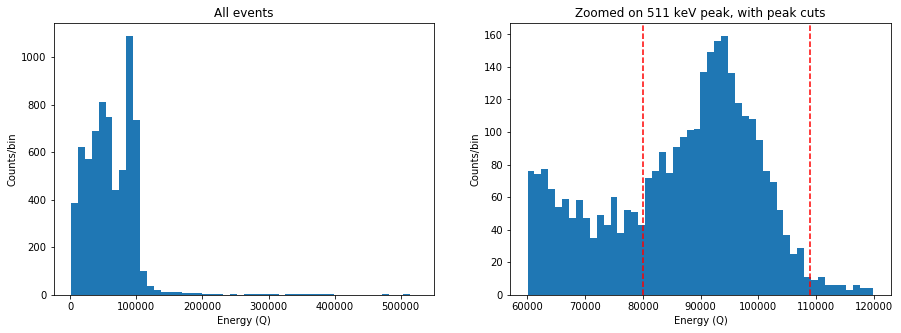

In [8]:
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# full energy spectrum
ax1 = fig.add_subplot(121);
plt.hist(l_etot,bins=50)
ax1.set_title("All events")
ax1.set_xlabel("Energy (Q)")
ax1.set_ylabel("Counts/bin")

# zoomed energy spectrum
ax2 = fig.add_subplot(122);
plt.hist(l_etot[((l_etot > 60000) & (l_etot < 120000))],bins=50)
plt.axvline(x=Ecut_low,color='red',linestyle='--')
plt.axvline(x=Ecut_high,color='red',linestyle='--')
ax2.set_title("Zoomed on 511 keV peak, with peak cuts")
ax2.set_xlabel("Energy (Q)")
ax2.set_ylabel("Counts/bin")

# zoomed, corrected energy
#ax3 = fig.add_subplot(133);
#plt.hist(l_etotcorr[((l_etotcorr > 150000) & (l_etotcorr < 200000))],bins=50)
#plt.axvline(x=Ecut_low,color='red',linestyle='--')
#plt.axvline(x=Ecut_high,color='red',linestyle='--')
#ax3.set_title("Zoomed on 511 keV peak, with peak cuts")
#ax3.set_xlabel("Energy (Q)")
#ax3.set_ylabel("Counts/bin")

### Plot blob energies for events in the peak 

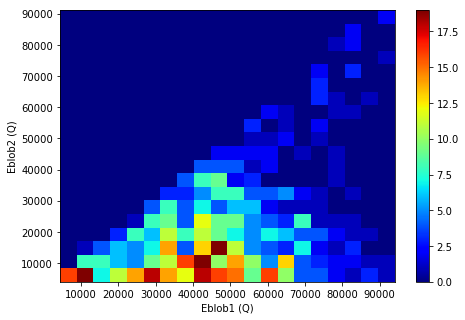

In [9]:
# 2D histogram
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(7.5);

# create the x-y projection
hxy, xxy, yxy = np.histogram2d(l_eblob1[((l_etot > Ecut_low) & (l_etot < Ecut_high) & (l_eblob1 > Ecut_low_blobs) & (l_eblob2 > Ecut_low_blobs))], l_eblob2[((l_etot > Ecut_low) & (l_etot < Ecut_high) & (l_eblob1 > Ecut_low_blobs) & (l_eblob2 > Ecut_low_blobs))], normed=False, bins=(20, 20))
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = plt.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
plt.xlabel("Eblob1 (Q)")
plt.ylabel("Eblob2 (Q)")
plt.colorbar()

### Plot track length vs. energy

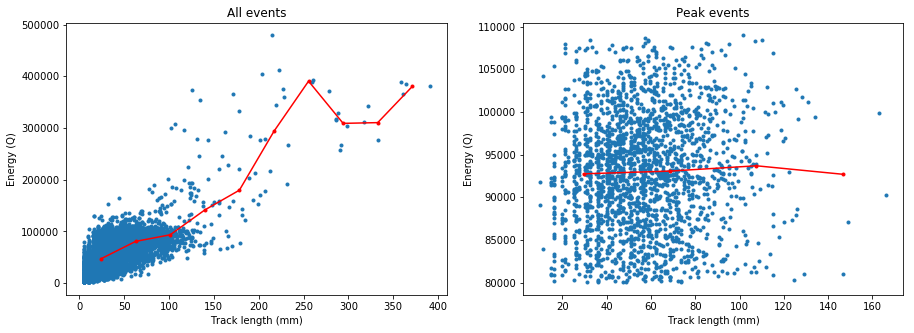

In [10]:
cuts_allE = (l_trklen < 400)
cuts_peakE = ((l_etot > Ecut_low) & (l_etot < Ecut_high))

fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# plot for all energies
ax1 = fig.add_subplot(121);
xcounts, xc_edges = np.histogram(l_trklen[cuts_allE],bins=10)
xhist, xbin_edges = np.histogram(l_trklen[cuts_allE],weights=l_etot[cuts_allE],bins=10)
xbin_width = xbin_edges[1] - xbin_edges[0]
xbin_centers = xbin_edges[:-1] + xbin_width/2.
xhist /= xcounts
plt.scatter(l_trklen[cuts_allE],l_etot[cuts_allE],marker='.')
plt.plot(xbin_centers,xhist,marker='.',color='red')
ax1.set_title("All events")
ax1.set_xlabel("Track length (mm)")
ax1.set_ylabel("Energy (Q)")

# plot for peak energies
ax2 = fig.add_subplot(122);
xcounts, xc_edges = np.histogram(l_trklen[cuts_peakE],bins=4)
xhist, xbin_edges = np.histogram(l_trklen[cuts_peakE],weights=l_etot[cuts_peakE],bins=4)
xbin_width = xbin_edges[1] - xbin_edges[0]
xbin_centers = xbin_edges[:-1] + xbin_width/2.
xhist /= xcounts
plt.scatter(l_trklen[cuts_peakE],l_etot[cuts_peakE],marker='.')
plt.plot(xbin_centers,xhist,marker='.',color='red')
ax2.set_title("Peak events")
ax2.set_xlabel("Track length (mm)")
ax2.set_ylabel("Energy (Q)")

### Print event numbers of selected events

In [14]:
cuts_peakE = ((l_etot > Ecut_low) & (l_etot < Ecut_high))
cuts_long = (l_trklen > 400)

print("Events in peak:")
pk_evts = [ii for ii,cc in enumerate(cuts_peakE) if cc]
print("Indices:",l_hcindex[pk_evts[0:10]])
print("With energies:",l_etot[pk_evts[0:10]])

print("\nLong events:")
long_evts = [ii for ii,cc in enumerate(cuts_long) if cc]
print("Indices:",l_hcindex[long_evts])
print("With length:",l_trklen[long_evts])
print("And energy:",l_etot[long_evts])

Events in peak:
Indices: [ 1  2  4  5  7  8  9 17 18 21]
With energies: [  97895.78857422   93647.75773621  100198.67700195   93211.83000183
   86242.86819458   97794.07162476   90939.12504578   93942.60995483
   88888.75759888   96209.24942017]

Long events:
Indices: [ 179  221  489  567 1359 1640 1782 2483 2512 2689 3768 4390 4581 4698 6482
 6517 6680]
With length: [ 603.3562093   421.67810465  490.54159983  506.18655085  428.56912266
  404.17023862  562.32305567  557.71125828  476.07698869  540.99552953
  748.14329595  838.22475511  428.71630892  709.79329761  484.14834658
  515.60732692  493.3938334 ]
And energy: [ 327282.78540039  384206.02276611  473043.31033325  420177.8137207
  498695.71331787  338935.60217285  524339.5111084   505380.16714478
  465873.77537537  374845.85461426  482047.3946228   488767.24461365
  392020.97268677  348345.9831543   511577.26741028  433912.0073967
  340206.05175781]
